# Installations & Imports


In [3]:
!nvidia-smi
!pip install -q -U watermark
!pip install -qq transformers==2.8.0
!pip install numpy==1.18.2
!pip install pandas 1.0.3
!pip install torch 1.4.0
#transformers 2.8.0
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
%matplotlib inline
%config InlineBackend.figure_format='retina'

Thu Apr 15 01:55:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

ERROR: Could not find a version that satisfies the requirement 1.0.3 (from versions: none)
ERROR: No matching distribution found for 1.0.3
ERROR: Could not find a version that satisfies the requirement 1.4.0 (from versions: none)
ERROR: No matching distribution found for 1.4.0
Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy       : 1.18.2
pandas      : 1.1.5
torch       : 1.8.1+cu101
transformers: 2.8.0



In [4]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Mounting

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
# Original Data Set:
#df = pd.read_csv("/content/drive/tweet_hate.csv")
df = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/BERT WORKS/tweet_hate.csv")

# Original, pre-processed
# df = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/originalPreProcess.csv")


df['cl'] = df['class']
"""
# Generated Data - no processing
dfGEN = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/genData200_1800.csv")
dfGEN = dfGEN[200:]
dfGEN = dfGEN.drop(columns=['index'])
dfGEN = dfGEN.reset_index()
dfGEN = dfGEN.rename(columns = {"level_0":"index"})

# Generate Data - preProcessing only
# dfGEN = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/preProcessedData1800.csv")

dfGEN = shuffle(dfGEN).reset_index(drop=True)

dfGEN"""


'\n# Generated Data - no processing\ndfGEN = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/genData200_1800.csv")\ndfGEN = dfGEN[200:]\ndfGEN = dfGEN.drop(columns=[\'index\'])\ndfGEN = dfGEN.reset_index()\ndfGEN = dfGEN.rename(columns = {"level_0":"index"})\n\n# Generate Data - preProcessing only\n# dfGEN = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/preProcessedData1800.csv")\n\ndfGEN = shuffle(dfGEN).reset_index(drop=True)\n\ndfGEN'

# Setting training and test data

In [34]:
# Original Data Set:
#df = pd.read_csv("/content/drive/tweet_hate.csv")
df = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/BERT WORKS/tweet_hate.csv")

# Original, pre-processed
# df = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/originalPreProcess.csv")


df['cl'] = df['class']
"""
# Generated Data - no processing
dfGEN = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/genData200_1800.csv")
dfGEN = dfGEN[200:]
dfGEN = dfGEN.drop(columns=['index'])
dfGEN = dfGEN.reset_index()
dfGEN = dfGEN.rename(columns = {"level_0":"index"})

# Generate Data - preProcessing only
# dfGEN = pd.read_csv("/content/drive/Shareddrives/CS522 term project - bullying hatespeech/preProcessedData1800.csv")

dfGEN = shuffle(dfGEN).reset_index(drop=True)

dfGEN"""

# TESTDATA
testData = df[df['class']!=1][3000:3200]
testData['cl'] = testData['class']


# TRAINING DATA - BASELINE EXPERIMENTS
# Uncomment your line

# 200
# df = df[df['class']!=1][0:200]

# 500
# df = df[df['class']!=1][0:500]

# 1000
df = df[df['class']!=1][0:1000]

# 2000
#df = df[df['class']!=1][0:2000]


# TRAINING DATA - WITH GENERATED DATA
df = df[df['class']!=1][0:2000]
#dfGEN = dfGEN[0:300]

# df = df[df['class']!=1][0:200]
# dfGEN = dfGEN[0:800]

# df = df[df['class']!=1][0:200]
# dfGEN = dfGEN[0:1800]


# Combining the original 200 + the generated data

#frames = [df, dfGEN]
#df = pd.concat(frames)
#
# Fix any NaN values
df["tweet"].fillna(" ", inplace = True)


df['cl'] = df['class']
df
# df = df[df['class']!=1][0:200]
df = df.reset_index(drop=True)

In [20]:
#df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_train = df
df_test = testData

df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
df_test

,class,tweet,cl,sentiment
13126,2,My phone on 10% fml I still gotta get to the y...,2,1
12757,2,Mann are first game is 3 weeks from now can't ...,2,1
12808,2,Me and this song bird sang in the same HS gosp...,2,1
13463,2,Note: Khorasan is the old Arabic name for part...,2,1
13328,0,Niggas deserve better bitches,0,0
...,...,...,...,...
13622,2,On the anniversary of 9/11 #ISIS &amp; Al Qaed...,2,1
13464,2,Nothing good on TV and the @Yankees are eating...,2,1
12714,2,Making brownies,2,1
12794,2,McDonald's is hella trash to me now,2,1


# Setup


In [43]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
MAX_LEN = 160
BATCH_SIZE = 16

In [44]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }


def to_sentiment(rating):
  rating = int(rating)
  if rating == 2:
    #return 2 # neither
    return 1
  else: 
    return 0 # Hate speech + offensive language


def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.tweet.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    #num_workers=4
    num_workers=0
  )
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

def train_epoch( 
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [45]:
df['sentiment'] = df.cl.apply(to_sentiment)
testData['sentiment'] = testData.cl.apply(to_sentiment)
#class_names = ['Hate Speech', 'Offensive Language', 'Neither']
class_names = ['Hate Speech', 'Neither']

In [46]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [47]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [48]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [49]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  1138,  1602,  3713, 11128,  1139,  1948,   119,   795,
          146,  4819,  1122,   117,  8499,  1500,  1287,   155,   119,   152,
          787, 19412,   117,  1103,  1393,  2084,  1104,  8499,  9761,  4556,
          111,   102])

In [50]:

tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'have',
 'black',
 'guys',
 'counting',
 'my',
 'money',
 '.',
 '…',
 'I',
 'hate',
 'it',
 ',',
 'Trump',
 'told',
 'John',
 'R',
 '.',
 'O',
 '’',
 'Donnell',
 ',',
 'the',
 'former',
 'president',
 'of',
 'Trump',
 'Plaza',
 'Hotel',
 '&',
 '[SEP]']

In [51]:
token_lens = []

for txt in df.tweet:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

In [52]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [53]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)



In [54]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [55]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [56]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4243, 0.5757],
        [0.6905, 0.3095],
        [0.5831, 0.4169],
        [0.4443, 0.5557],
        [0.5536, 0.4464],
        [0.4736, 0.5264],
        [0.6332, 0.3668],
        [0.3923, 0.6077],
        [0.5306, 0.4694],
        [0.5164, 0.4836],
        [0.6434, 0.3566],
        [0.5038, 0.4962],
        [0.4488, 0.5512],
        [0.4906, 0.5094],
        [0.3882, 0.6118],
        [0.5661, 0.4339]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [57]:
EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [59]:
#%%time

history = defaultdict(list)
best_accuracy = 0


for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------


RuntimeError: ignored

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA
#For more tuning if needed
# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

# Checking score

In [39]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [40]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [41]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 Hate Speech       0.83      0.79      0.81        19
     Neither       0.95      0.96      0.96        81

    accuracy                           0.93       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.93      0.93      0.93       100



# Misc

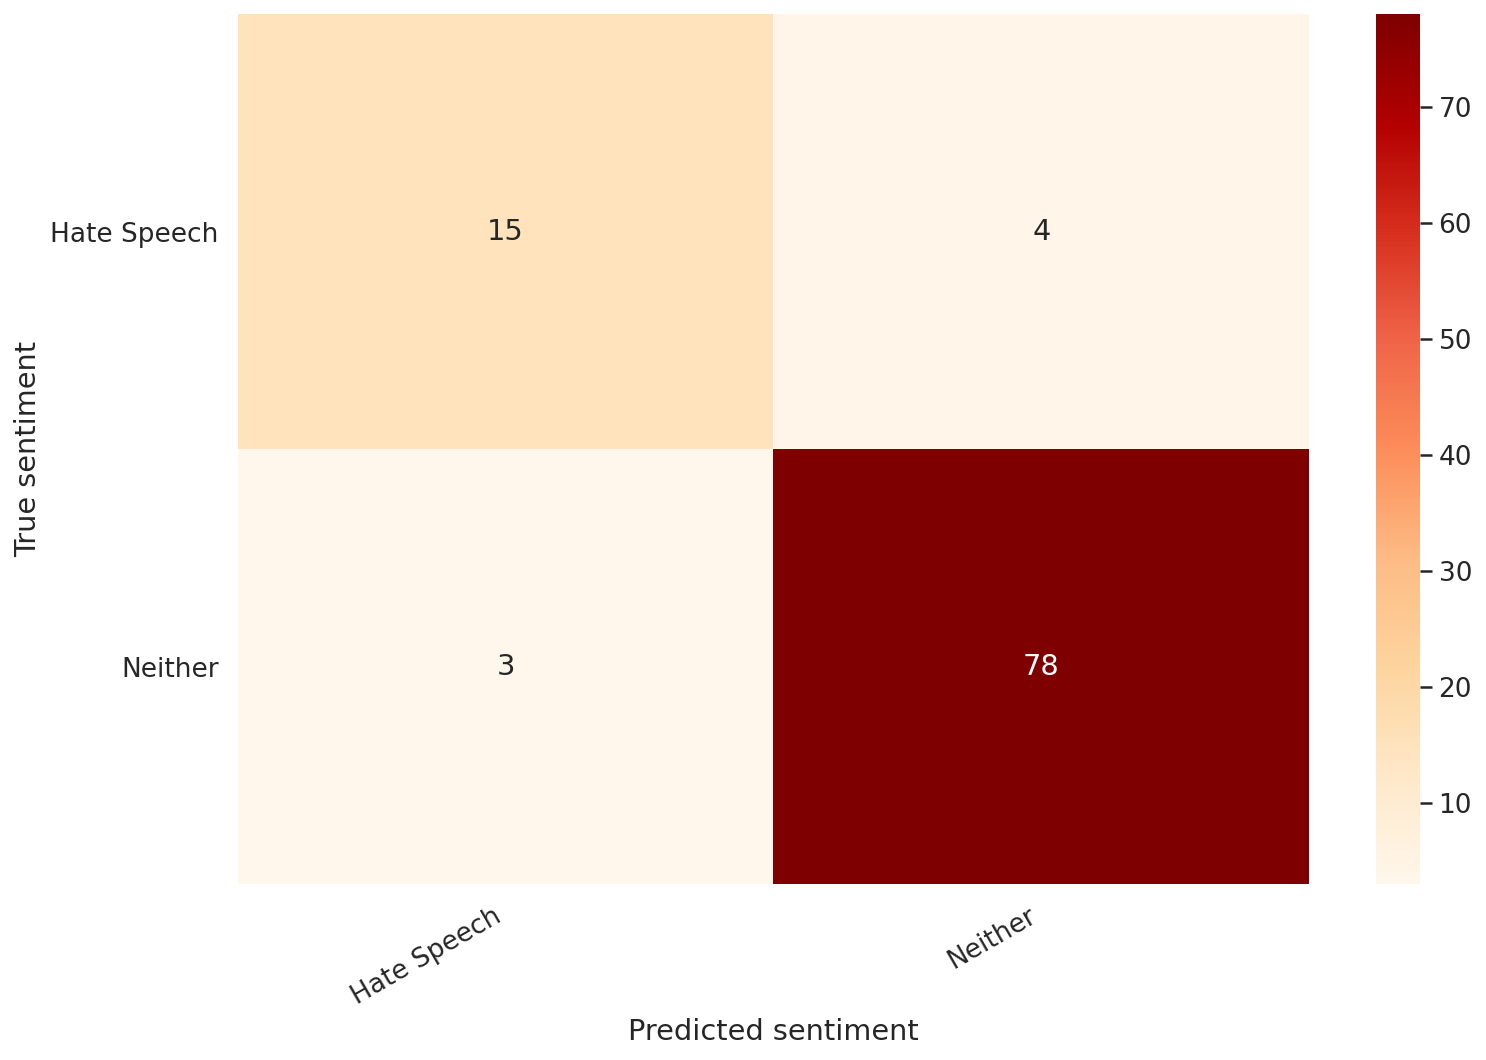

In [42]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="OrRd")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:

idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [ ]:
sample_txt = "They’re bringing drugs, they’re bringing crime, they’re rapists, and some I assume are good people"

In [ ]:
tt = "#WorthLaying #SellForMentors https://t.co/B4RYxhWUr8 https://t.co/9ZhvDtFW3H https://t.co/nL6s0HX5Gr pic.twitter.com/vzh1MzQnq5 — Rachel St. John (@RachelStJohn) January 27, 2017 I have a woman who owns a home owned by a white man who goes into one because they're wealthy. So I'm not gonna tell you I go to see if she owns anything because my mother goes into that house because the owner is white. I want to see if my stepfather owns something because they're doing all of that... pic.twitter.com/OeJMnwV2g6 — Danielle Sorensen (@danisorensen) January 19, 2017 Here's an example of this on Facebook:"

In [ ]:

encoded_review = tokenizer.encode_plus(
  tt,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Test text: {tt}')
print(f'Sentiment  : {class_names[prediction]}')

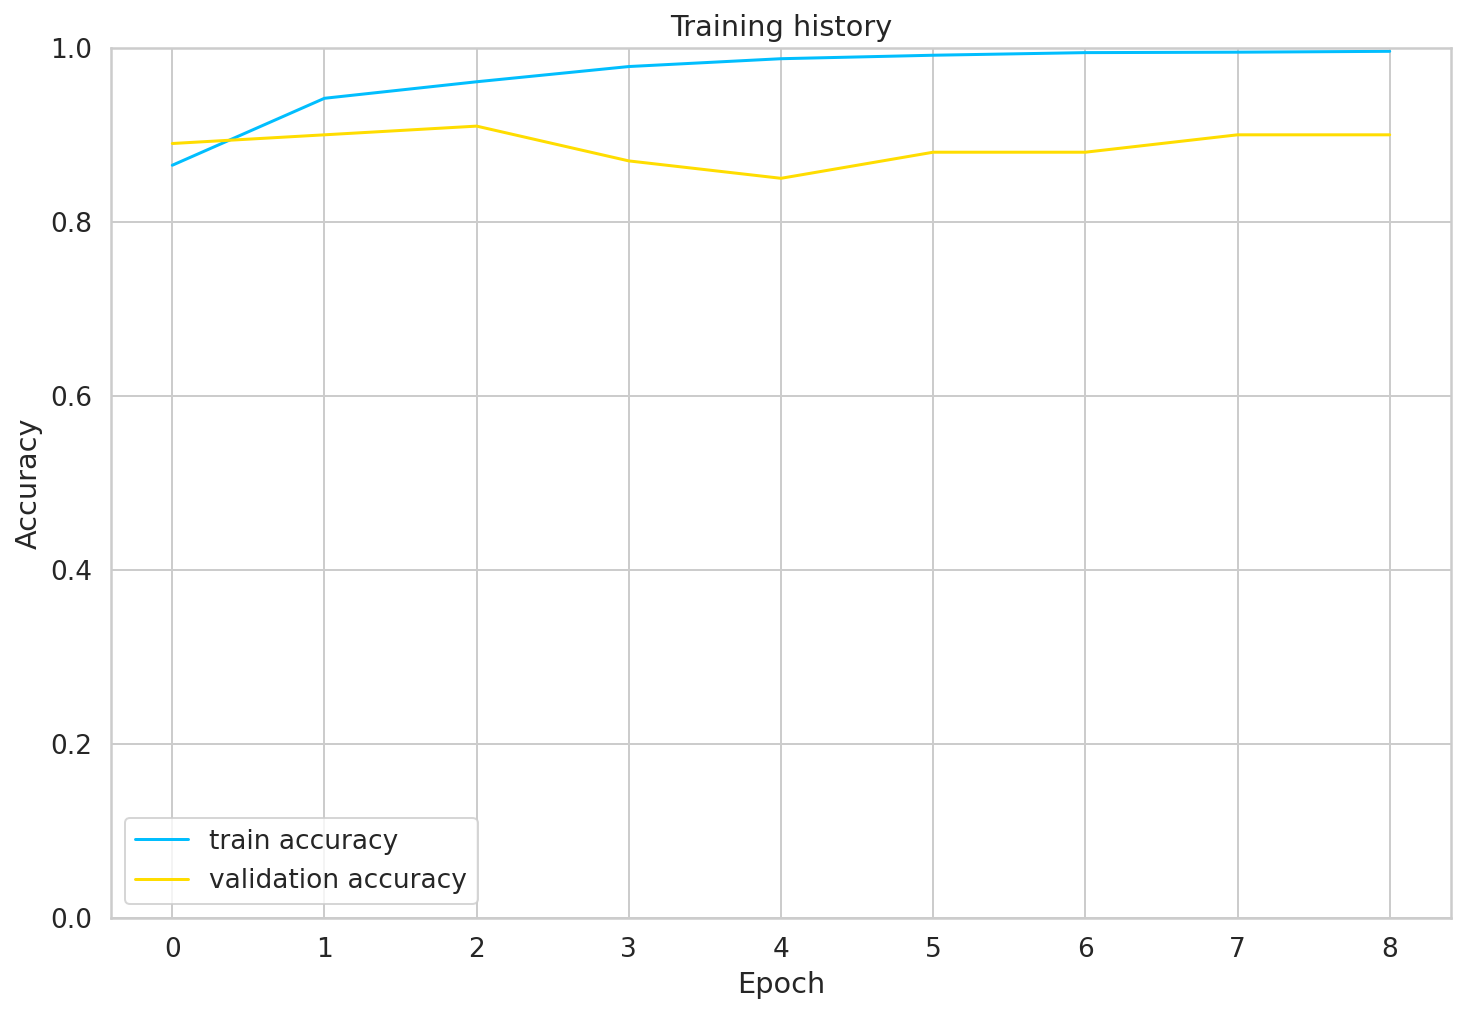

In [37]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
sample_txt = 'I have black guys counting my money. … I hate it, Trump told John R. O’Donnell, the former president of Trump Plaza Hotel & Casino, according O’Donnell’s account in his 1991 book Trumped!The only guys I want counting my money are short guys that wear yarmulkes all day.Trump, according to O’Donnell, went on to say,Laziness is a trait in blacks. It really is, I believe that.'
#from nltk.tokenize import word_tokenize
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id
tokenizer.cls_token, tokenizer.cls_token_id
tokenizer.pad_token, tokenizer.pad_token_id
tokenizer.unk_token, tokenizer.unk_token_id

('[CLS]', 101)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


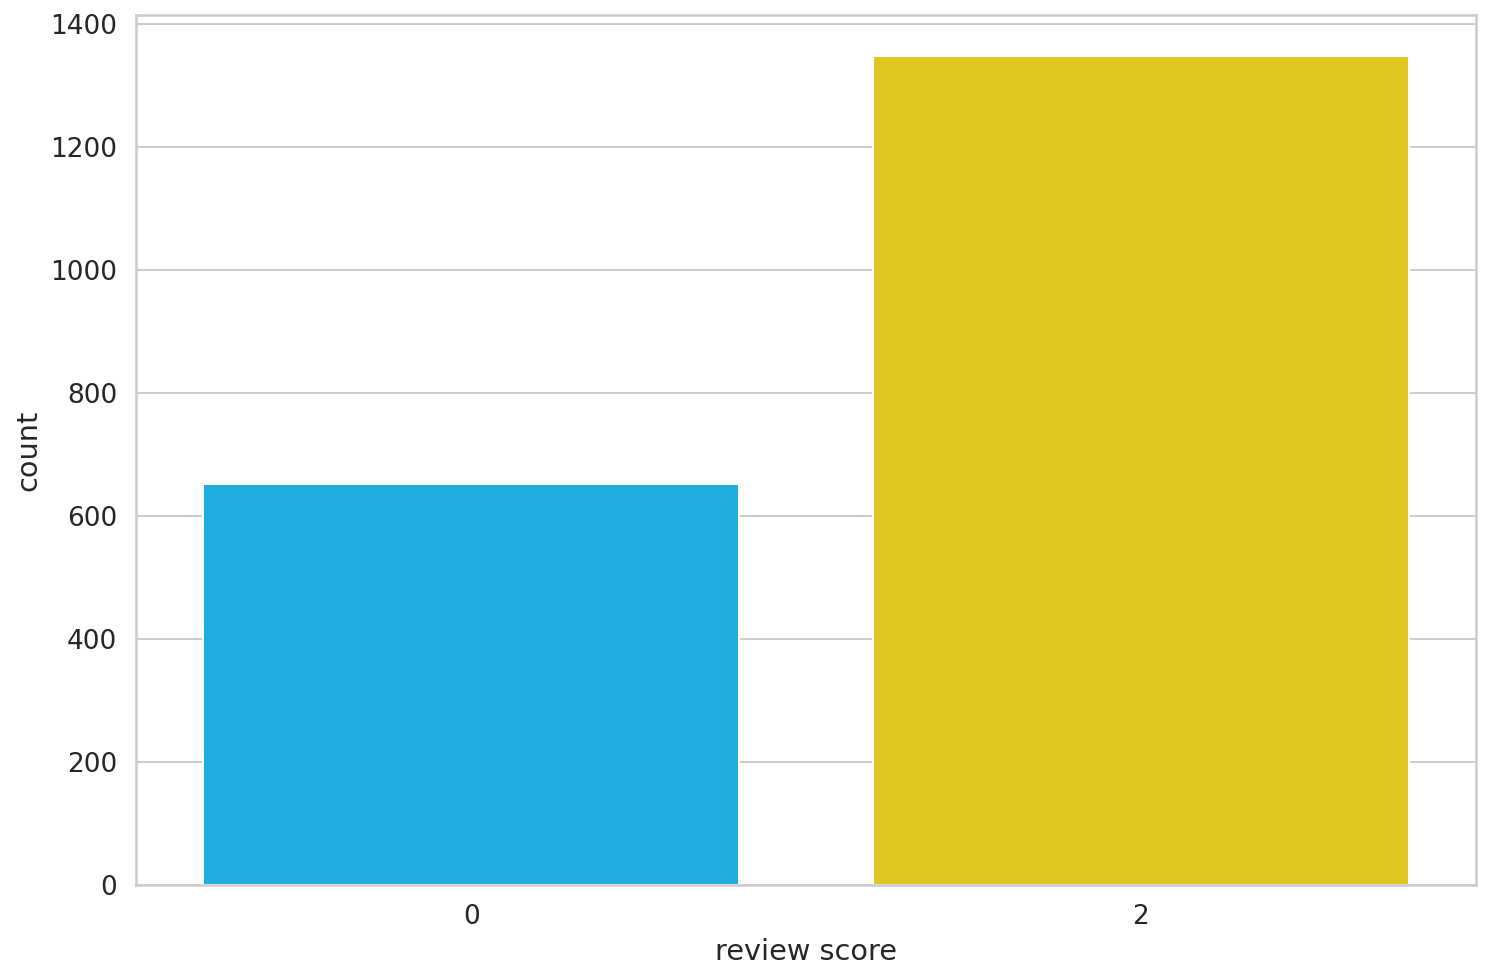

In [ ]:
sns.countplot(df.cl)
plt.xlabel('review score');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


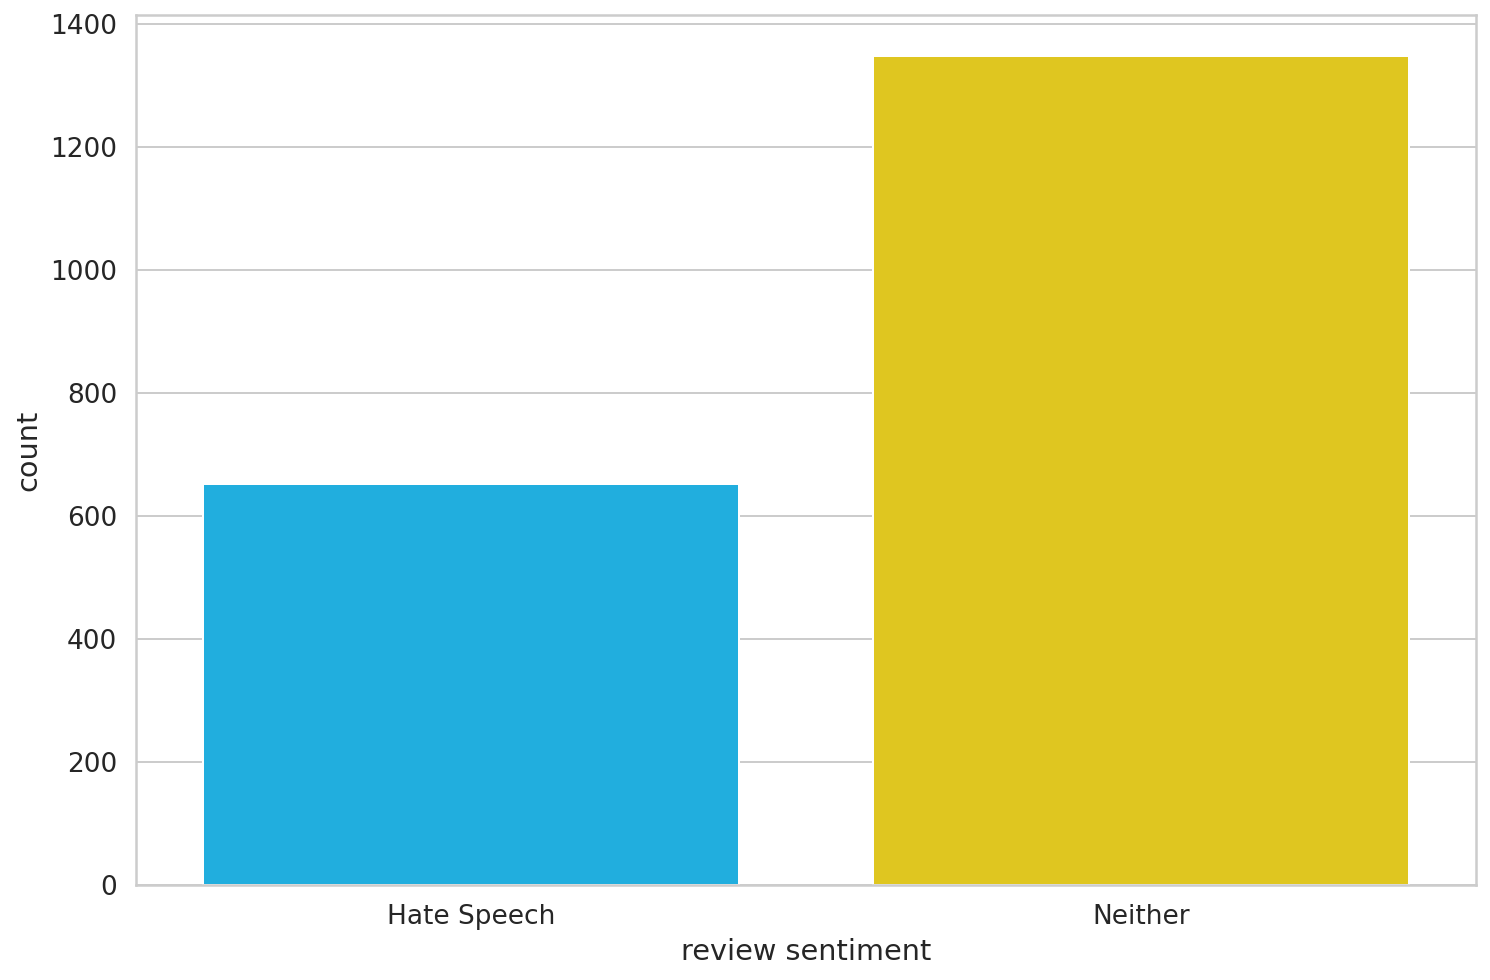

In [11]:
ax = sns.countplot(df.cl)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)